In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
def initialize_lattice(N):
    return np.random.choice([1, -1], size=(N, N))

@njit
def calculate_energy(lattice, i, j, J, H):
    sigma_ij = lattice[i, j]
    M = lattice[(i + 1) % N, j] + lattice[(i - 1) % N, j] + \
        lattice[i, (j + 1) % N] + lattice[i, (j - 1) % N]
    
    E_plus = -(H + J*M)
    E_minus = H + J*M
    
    return E_plus, E_minus

@njit
def monte_carlo_step(lattice, N, T, J, H):
    beta = 1 / T
    num_atoms_to_update = int(0.1*N*N)   # Update 10% of atoms
    
    for _ in range(num_atoms_to_update):
        i, j = np.random.randint(0, N, 2)
        E_plus, E_minus = calculate_energy(lattice, i, j, J, H)
        p_pos = np.exp(-beta*E_plus) / (np.exp(-beta*E_plus) + np.exp(-beta*E_minus))
        
        if np.random.random() < p_pos:
            lattice[i, j] = 1
        else:   # complementary probability
            lattice[i, j] = -1
            
    return lattice

## Snapshots of the binary spin map (T<Tc, T=Tc, T>Tc)

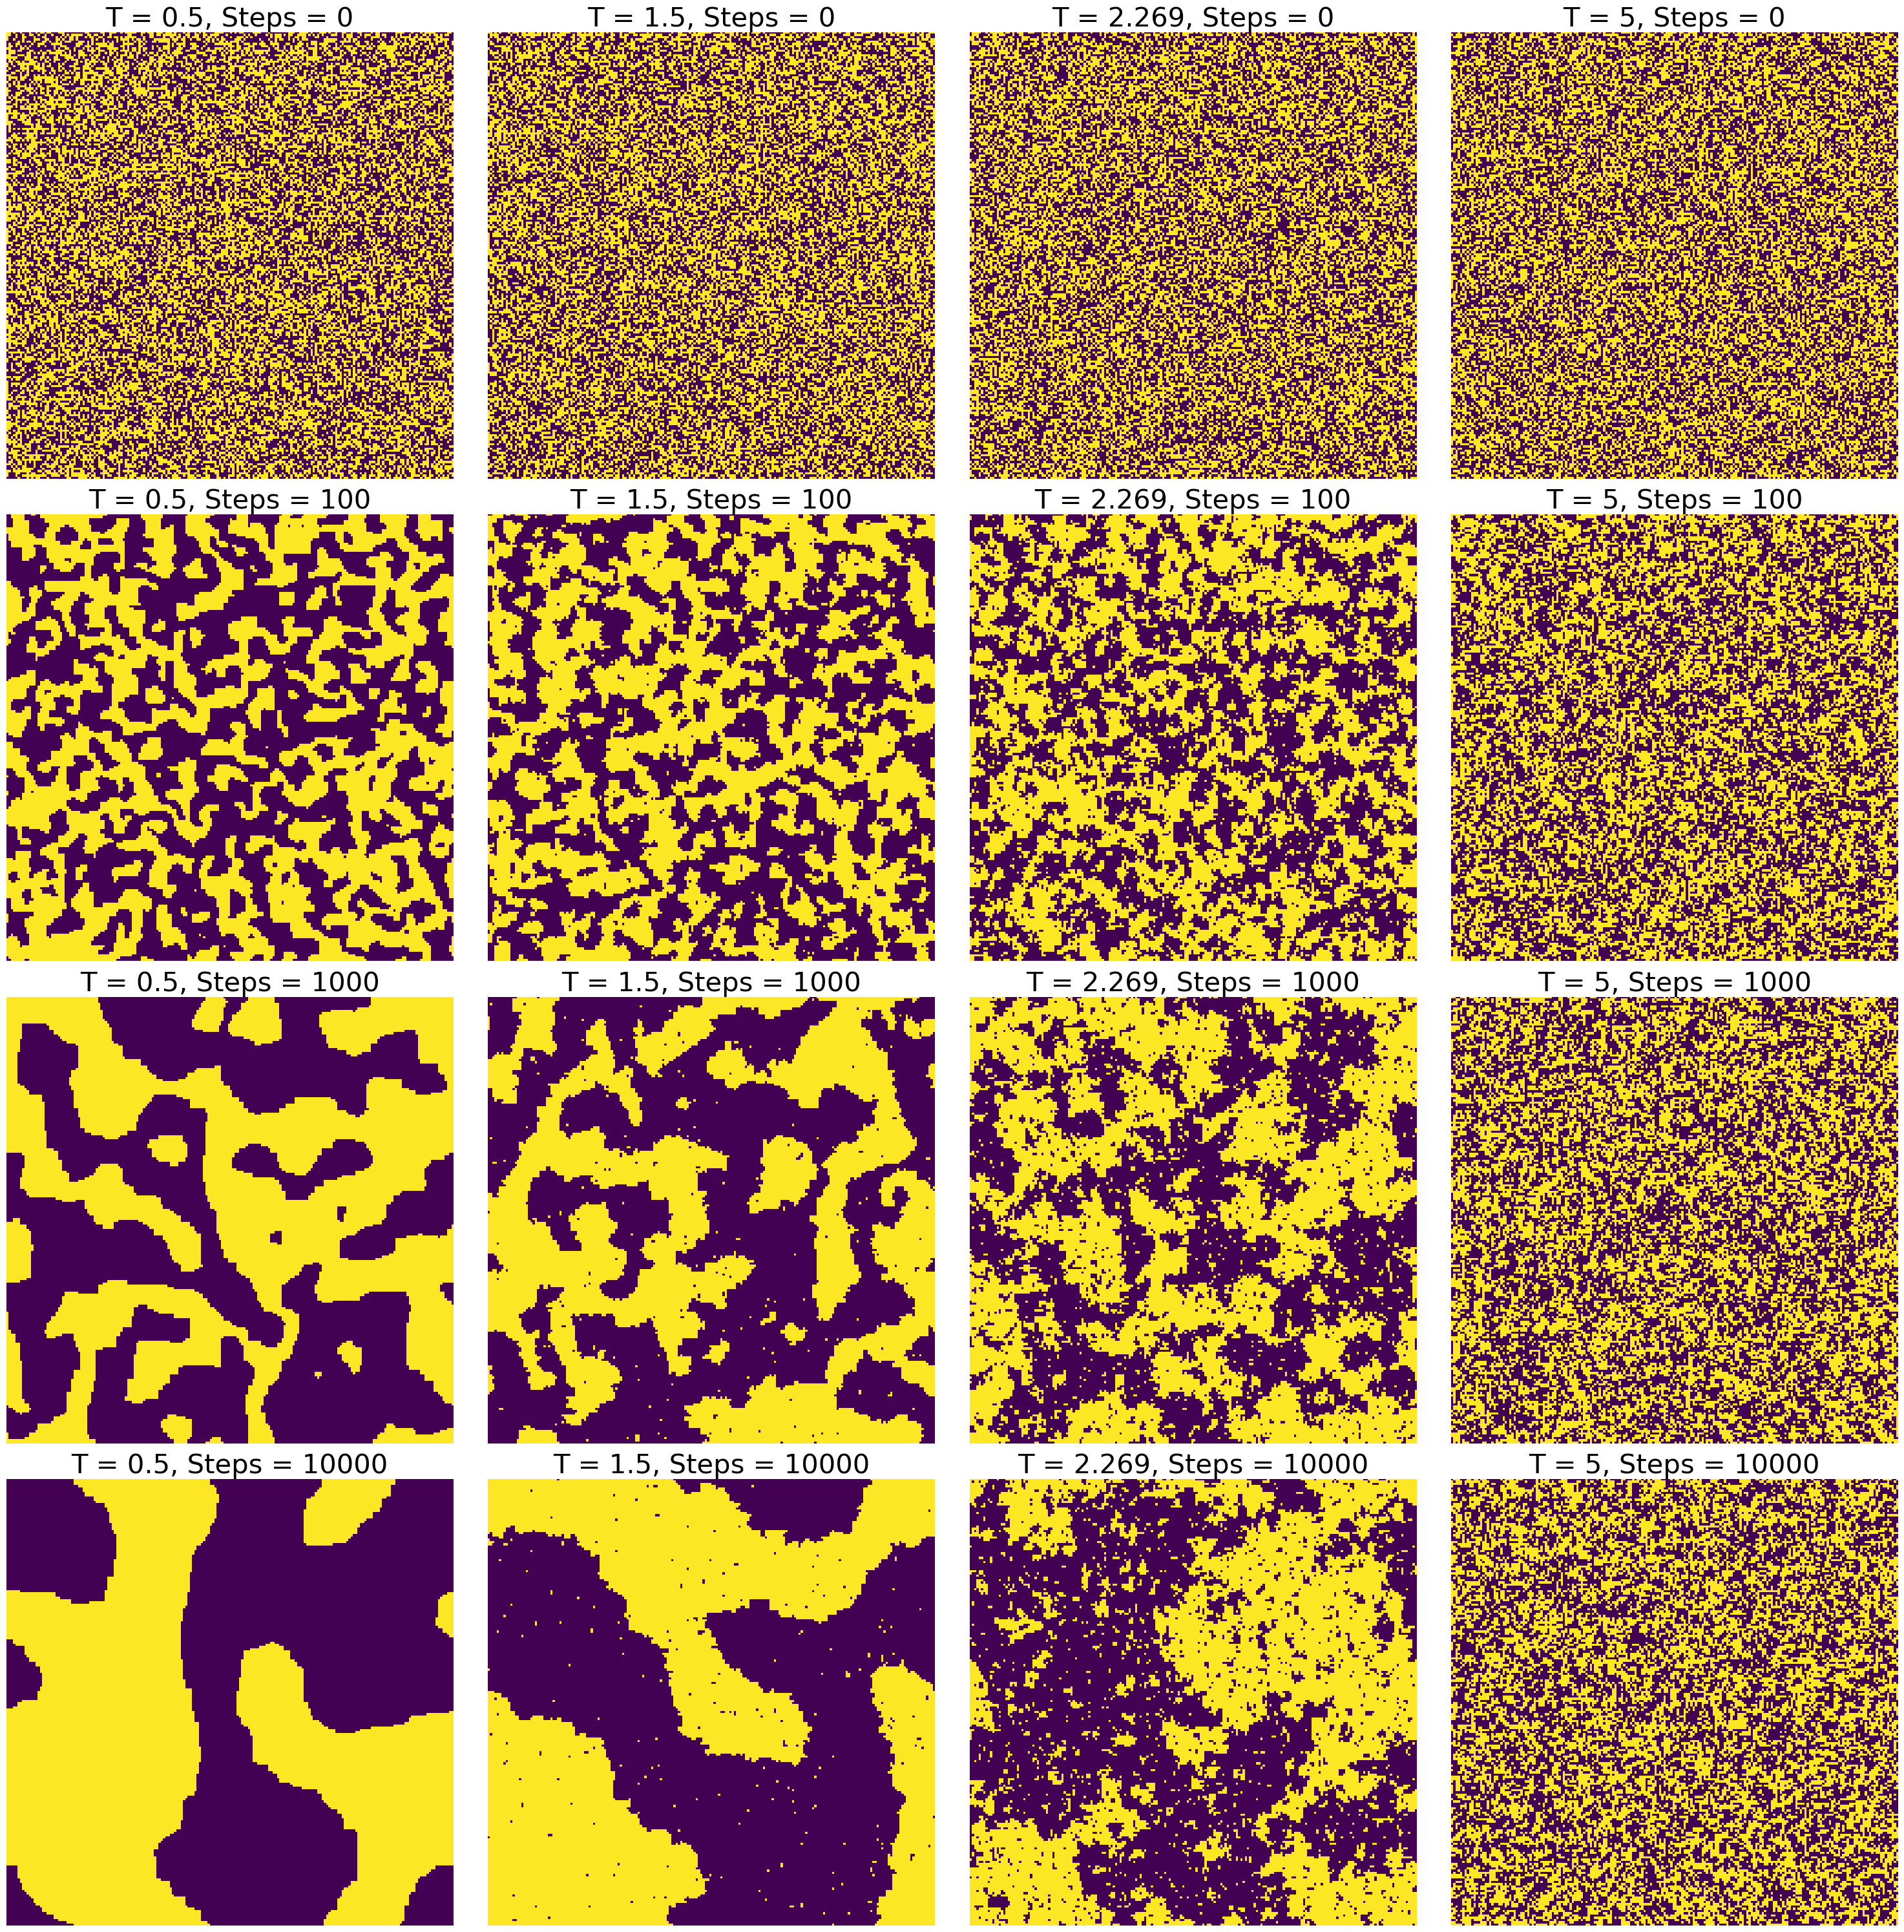

In [3]:
H = 0
N = 200   # 200x200 atoms
J = 1   # Note, if J<0 => antiferromagnetic
temperatures = [0.5, 1.5, 2.269, 5]   # 2.269 = Tc
steps = [0, 100, 1000, 10000]


fig, axes = plt.subplots(4, 4, figsize=(30, 30))

for row, steps in enumerate(steps):
    for col, T in enumerate(temperatures):
        lattice = initialize_lattice(N)
        for step in range(steps):
            lattice = monte_carlo_step(lattice, N, T, J, H)
        axes[row, col].imshow(lattice, cmap='viridis', interpolation='none')
        axes[row, col].set_title(f'T = {T}, Steps = {steps}', fontsize=30)
        axes[row, col].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout()
plt.show()

Critical temperature at $T_c = 2.269$.

Below this point, $T<T_c$ (to the left) we have the subcritical regime. Here, the magnetic states converge into permanent domains (with spins +-1). Meaning, that the spins are mostly aligned with each other, therefore getting the domains of +1 or -1 spins.

Above this point, $T>T_c$ (to the right) we have the supercritical regime. Thermal fluctuations dominate and disrubt order. Spins become more random (noisy) and disordered. Here, the system no longer has a global magnetization.

--------------------
Low temperature --> the systems is minimizing its energy. And it's energitically favorable for spins to align with neighbors.

High temperature --> Thermal fluctuations become dominant and disrupt order leading to randomness and noisiness.

--------------------

## Showing that 2D Ising model behaves like a paramagnetic material at high temperatures

The binary spin map for $T=5$ are shown above. At this high temperature, thermal energy is high enough to disrupt the alignments of the spin. Instead it will appear random and noisy, no clear magnetic domains. This is characteristic of paramagnetic material where thermal fluctuations dominate, leading to a net magnetization close to zero.

In [4]:
@njit
def calculate_magnetization(lattice):
    m = np.sum(lattice) / (N**2)   # Eq. 2.3
    return m

In [5]:
# Lattice for T=5
T = 5
N = 200
H = 0
J = 1
steps = 10000

high_T_lattice = initialize_lattice(N)
for step in range(steps):
    high_T_lattice = monte_carlo_step(high_T_lattice, N, T, J, H)
    
magnetization_high_T = calculate_magnetization(high_T_lattice)

print(f"Magnetization at T = 5: {magnetization_high_T:.3f}")

Magnetization at T = 5: -0.000


As we can see, the magnetization $m≈0.000$. Meaning no magnetization, spins are, on average, not aligned in direction or groups. This means that (almost) half of the spins are up (+1) and half (-1), leading to net $m$ close to $0$.

## Magnetization and susceptibility for small values of the external magnetic field (H)

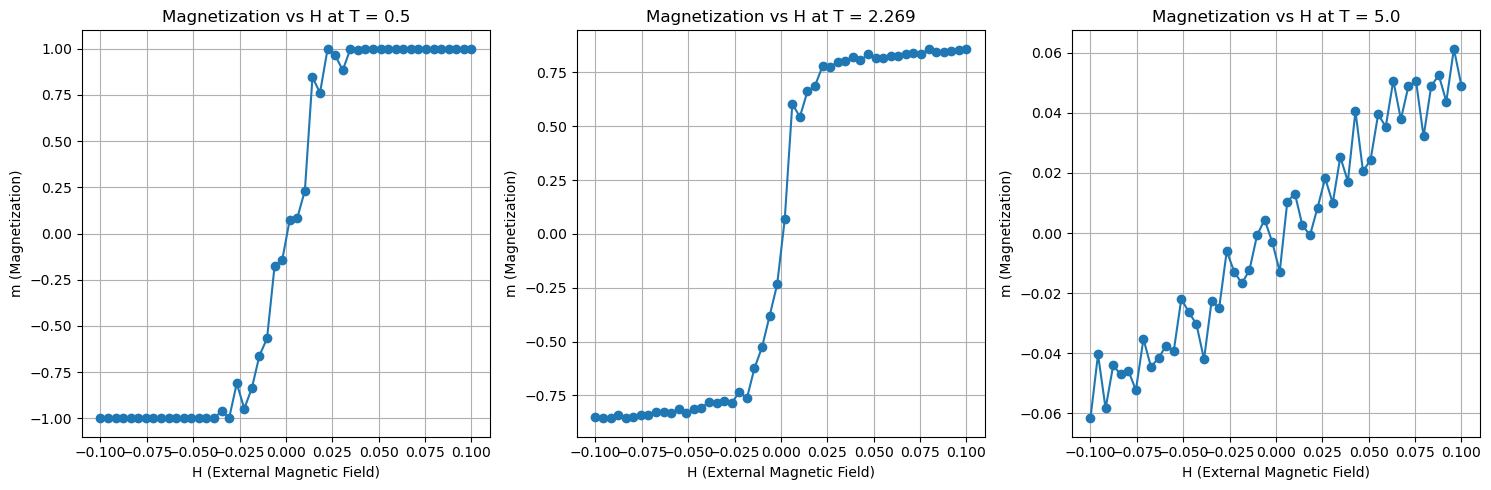

In [6]:
# Different T below, above and Tc
T = [0.5, 2.269, 5.0]
num_steps = 5000
H_values = np.linspace(-0.1, 0.1, 50)  # 50 small values of H around 0

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop over each temperature
for index, Temp in enumerate(T):
    magnetizations = []
    for H in H_values:
        lattice = initialize_lattice(N)
        for step in range(num_steps):
            lattice = monte_carlo_step(lattice, N, Temp, J, H)
        magnetizations.append(calculate_magnetization(lattice))

    # Plot m against H on the subplot
    axes[index].plot(H_values, magnetizations, 'o-')
    axes[index].set_xlabel('H (External Magnetic Field)')
    axes[index].set_ylabel('m (Magnetization)')
    axes[index].set_title(f'Magnetization vs H at T = {Temp}')
    axes[index].grid(True)

plt.tight_layout()
plt.show()

The susceptibility is the slope of m(H) curve around zero, where the curve is a line.

At $T=0.5$, susceptibility $\chi≈45$

At $T=T_c=2.269$, susceptibility $\chi≈60$

At $T=5$, susceptibility $\chi=0.06$